In [1]:
from preprocess import *

data_path = "data/epinions.txt"

preprocess(data_path, rating_minimum=20)

Processed 10000 lines
Processed 20000 lines
Processed 30000 lines
Processed 40000 lines
Processed 50000 lines
Processed 60000 lines
Processed 70000 lines
Processed 80000 lines
Processed 90000 lines
Processed 100000 lines
Processed 110000 lines
Processed 120000 lines
Processed 130000 lines
Processed 140000 lines
Processed 150000 lines
Processed 160000 lines
Processed 170000 lines
Processed 180000 lines
Processed 190000 lines
Number of users: 335
Number of items: 8999
Number of interactions: 10348
Sparsity: 0.9965674461341476


/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_data = pd.concat([train_data, user_data[:split_index]])
/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_data = pd.concat([test_data, user_data[split_index:]])
/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

Train data: 8142
Validation data: 1010
Test data: 1196
Train ratings distribution:
rating
5.0    3405
4.0    2903
3.0    1125
2.0     417
1.0     292
Name: count, dtype: int64
Validation ratings distribution:
rating
5.0    409
4.0    401
3.0    119
2.0     49
1.0     32
Name: count, dtype: int64
Test ratings distribution:
rating
5.0    516
4.0    445
3.0    144
2.0     56
1.0     35
Name: count, dtype: int64
Train ratings percentage:
rating
5.0    0.418202
4.0    0.356546
3.0    0.138172
2.0    0.051216
1.0    0.035863
Name: proportion, dtype: float64
Validation ratings percentage:
rating
5.0    0.404950
4.0    0.397030
3.0    0.117822
2.0    0.048515
1.0    0.031683
Name: proportion, dtype: float64
Test ratings percentage:
rating
5.0    0.431438
4.0    0.372074
3.0    0.120401
2.0    0.046823
1.0    0.029264
Name: proportion, dtype: float64


In [5]:
import pickle
import torch
from epinions_dataset import EpinionsDataset
import pandas as pd
from torch.utils.data import DataLoader

# Get user to items dictionary from pickle file
with open('data/user_to_item.pkl', 'rb') as f:
    user_to_items = pickle.load(f)

# Get items set from pickle file
with open('data/items.pkl', 'rb') as f:
    items_set = pickle.load(f)

# Create datasets
train_df = pd.read_csv('data/train_data_20.csv')
val_df = pd.read_csv('data/validation_data_20.csv')
test_df = pd.read_csv('data/test_data_20.csv')

train_dataset = EpinionsDataset(train_df, user_to_items, items_set)
val_dataset = EpinionsDataset(val_df, user_to_items, items_set)
test_dataset = EpinionsDataset(test_df, user_to_items, items_set)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# create a weighted MSE loss function 

class WeightedMSELoss(torch.nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

        weights = {}

        # Get counts for each rating in training dataset 
        for i in range(1, 6):
            weights[float(i)] = len(train_df[train_df['rating'] == i])

        # get max count
        max_count = max(weights.values())

        # calculate weights
        for i in range(1, 6):
            weights[float(i)] = max_count / weights[i]

        self.weights = weights

    def forward(self, input, target):
        return torch.mean(self.weights[target] * (input - target) ** 2)

In [7]:
from tqdm import tqdm

def train(model, train_loader, val_loader, epochs, optimizer, criterion):
    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        for i, (user, item, target) in tqdm(enumerate(train_loader), desc=f'Training, Epoch {epoch+1}', total=len(train_loader)):
            optimizer.zero_grad()
            output = model(user, item)
            output = output * 4 + 1

            rounded_output = torch.round(output)
            train_accuracy += torch.sum(rounded_output == target).item() / target.size(0)

            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_accuracy / len(train_loader))

        model.eval()
        val_loss = 0
        val_accuracy = 0
        for user, item, target in val_loader:
            output = model(user, item)

            # scale output to be between 1 and 5
            output = output * 4 + 1

            rounded_output = torch.round(output)
            val_accuracy += torch.sum(rounded_output == target).item() / target.size(0)

            loss = criterion(output, target)
            val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_accuracy / len(val_loader))
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]} Train Accuracy: {train_accs[-1]} | Validation Loss: {val_losses[-1]} Validation Accuracy: {val_accs[-1]}')

    return train_losses, val_losses, train_accs, val_accs

In [13]:
from ncf import NCF

# Create NCF model
user_input_dim = len(user_to_items)
item_input_dim = len(items_set)
hidden_layers = [64, 32]
embedding_dim = 1024
model = NCF(user_input_dim, item_input_dim, embedding_dim, hidden_layers[0], hidden_layers[1])
#criterion = torch.nn.MSELoss()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, 20, optimizer, criterion)

Training, Epoch 1: 100%|██████████| 128/128 [00:06<00:00, 21.11it/s]


Epoch: 1, Train Loss: 1.0991281236056238 Train Accuracy: 0.384033203125 | Validation Loss: 0.9357349574565887 Validation Accuracy: 0.4148046875


Training, Epoch 2: 100%|██████████| 128/128 [00:05<00:00, 22.21it/s]


Epoch: 2, Train Loss: 0.6618033964186907 Train Accuracy: 0.5276750837053571 | Validation Loss: 1.133432775735855 Validation Accuracy: 0.339453125


Training, Epoch 3: 100%|██████████| 128/128 [00:05<00:00, 22.63it/s]


Epoch: 3, Train Loss: 0.5353303111623973 Train Accuracy: 0.6302490234375 | Validation Loss: 1.1064850650727749 Validation Accuracy: 0.4114453125


Training, Epoch 4: 100%|██████████| 128/128 [00:05<00:00, 22.71it/s]


Epoch: 4, Train Loss: 0.38929936953354627 Train Accuracy: 0.7118791852678571 | Validation Loss: 1.083215158432722 Validation Accuracy: 0.3977734375


Training, Epoch 5: 100%|██████████| 128/128 [00:05<00:00, 22.70it/s]


Epoch: 5, Train Loss: 0.26514399392181076 Train Accuracy: 0.7784423828125 | Validation Loss: 1.188957903534174 Validation Accuracy: 0.3535546875


Training, Epoch 6: 100%|██████████| 128/128 [00:05<00:00, 22.65it/s]


Epoch: 6, Train Loss: 0.19991521775955334 Train Accuracy: 0.831787109375 | Validation Loss: 1.2551529370248318 Validation Accuracy: 0.325234375


Training, Epoch 7: 100%|██████████| 128/128 [00:05<00:00, 22.64it/s]


Epoch: 7, Train Loss: 0.17313071322860196 Train Accuracy: 0.8504987444196429 | Validation Loss: 1.2023994214832783 Validation Accuracy: 0.3444921875


Training, Epoch 8: 100%|██████████| 128/128 [00:05<00:00, 22.48it/s]


Epoch: 8, Train Loss: 0.15922219355707057 Train Accuracy: 0.864501953125 | Validation Loss: 1.2273847982287407 Validation Accuracy: 0.349921875


Training, Epoch 9: 100%|██████████| 128/128 [00:05<00:00, 22.59it/s]


Epoch: 9, Train Loss: 0.1454733089194633 Train Accuracy: 0.8754185267857143 | Validation Loss: 1.188383836299181 Validation Accuracy: 0.3697265625


Training, Epoch 10: 100%|██████████| 128/128 [00:05<00:00, 22.65it/s]


Epoch: 10, Train Loss: 0.12801908094843384 Train Accuracy: 0.8875034877232143 | Validation Loss: 1.1830676943063736 Validation Accuracy: 0.3905078125


Training, Epoch 11: 100%|██████████| 128/128 [00:05<00:00, 22.60it/s]


Epoch: 11, Train Loss: 0.1275884527422022 Train Accuracy: 0.8881661551339286 | Validation Loss: 1.2088835760951042 Validation Accuracy: 0.3753125


Training, Epoch 12: 100%|██████████| 128/128 [00:05<00:00, 22.51it/s]


Epoch: 12, Train Loss: 0.12164092864259146 Train Accuracy: 0.8976876395089286 | Validation Loss: 1.3236271254718304 Validation Accuracy: 0.3176953125


Training, Epoch 13: 100%|██████████| 128/128 [00:05<00:00, 22.64it/s]


Epoch: 13, Train Loss: 0.11215613997774199 Train Accuracy: 0.9014718191964286 | Validation Loss: 1.1557610891759396 Validation Accuracy: 0.40390625


Training, Epoch 14: 100%|██████████| 128/128 [00:05<00:00, 22.66it/s]


Epoch: 14, Train Loss: 0.11594742437591776 Train Accuracy: 0.8985246930803571 | Validation Loss: 1.2888498306274414 Validation Accuracy: 0.36734375


Training, Epoch 15: 100%|██████████| 128/128 [00:05<00:00, 22.57it/s]


Epoch: 15, Train Loss: 0.1155636960756965 Train Accuracy: 0.9000069754464286 | Validation Loss: 1.2778188809752464 Validation Accuracy: 0.368203125


Training, Epoch 16: 100%|██████████| 128/128 [00:05<00:00, 22.69it/s]


Epoch: 16, Train Loss: 0.11341785814147443 Train Accuracy: 0.9049072265625 | Validation Loss: 1.2078465446829796 Validation Accuracy: 0.3944140625


Training, Epoch 17: 100%|██████████| 128/128 [00:05<00:00, 22.85it/s]


Epoch: 17, Train Loss: 0.10634610947454348 Train Accuracy: 0.9095458984375 | Validation Loss: 1.2729322910308838 Validation Accuracy: 0.3599609375


Training, Epoch 18: 100%|██████████| 128/128 [00:05<00:00, 22.96it/s]


Epoch: 18, Train Loss: 0.09884799041901715 Train Accuracy: 0.9143415178571429 | Validation Loss: 1.24835741892457 Validation Accuracy: 0.3887109375


Training, Epoch 19: 100%|██████████| 128/128 [00:05<00:00, 23.01it/s]


Epoch: 19, Train Loss: 0.09489003295311704 Train Accuracy: 0.9187534877232143 | Validation Loss: 1.4135019890964031 Validation Accuracy: 0.3528515625


Training, Epoch 20: 100%|██████████| 128/128 [00:05<00:00, 22.95it/s]


Epoch: 20, Train Loss: 0.10124407980765682 Train Accuracy: 0.9140450613839286 | Validation Loss: 1.1771347634494305 Validation Accuracy: 0.411171875


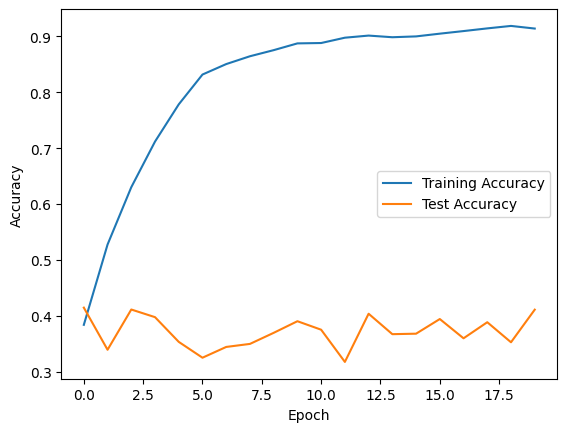

In [14]:
import matplotlib.pyplot as plt

rms_train_losses = [x ** 0.5 for x in train_losses]
rms_val_losses = [x ** 0.5 for x in val_losses]

plt.plot(rms_train_losses, label='RMS Training Loss')
plt.plot(rms_val_losses, label='RMS Test Loss')
plt.xlabel('Epoch')
plt.ylabel('RMS Loss')
plt.legend()
plt.savefig('ratings_prediction_loss.png')

plt.clf()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ratings_prediction_accuracy.png')

In [15]:
# Best test accuracy
best_val_acc = max(val_accs)
print(f'Best validation accuracy: {best_val_acc}')

# Best test loss
best_val_loss = min(rms_val_losses)
print(f'Best validation loss: {best_val_loss}')

Best validation accuracy: 0.4148046875
Best validation loss: 0.9673339430913136
